In [7]:
import json
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
from scipy.spatial.transform import Rotation
from sklearn.cluster import KMeans, DBSCAN
from tqdm import tqdm
from tools.visual_utils.open3d_vis_utils import draw_scenes
import pickle as pkl

#%matplotlib widget

## Functions

In [8]:
def read_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

def read_npy(filename):
    data = np.load(filename)
    return data

def read_pkl(filename):
    with open(filename, 'rb') as f:
        data = pkl.load(f)
    return data

def read_file(filename):
    #load file based on extension
    if filename.endswith('.json'):
        data = read_json(filename)
    elif filename.endswith('.npy'):
        data = read_npy(filename)
    elif filename.endswith('.pkl'):
        data = read_pkl(filename)
    else:
        raise Exception("Unknown file extension")
    return data

def plot_polar_image(phi, theta, beam_labels, ylim=None):
    #beam labels to int
    beam_labels = beam_labels.astype(int)

    #convert beam label to color
    colors = [0, 0.5, 1]
    #alternate colors for visualization
    color = np.zeros((beam_labels.shape[0]))
    for i in range(beam_labels.shape[0]):
        color[i] = colors[beam_labels[i] % 3]
        
    #plot polar image
    plt.figure()
    plt.scatter(phi, theta, s=0.1, c=color, cmap='jet')
    plt.xlabel('Theta (radians)')
    plt.ylabel('Phi (radians)')
    if ylim :
        plt.ylim(ylim)
    plt.show()

def beam_label(theta, beam, method='kmeans'):
    if method == 'kmeans++':
        estimator=KMeans(n_clusters=beam, init='k-means++', n_init="auto")
    elif method == 'kmeans':
        estimator=KMeans(n_clusters=beam, init='random', n_init='auto')
    elif method == 'dbscan':
        estimator=DBSCAN(eps=0.1, min_samples=10)
   
    res=estimator.fit_predict(theta.reshape(-1, 1))
    label=estimator.labels_

    #sort beam index based on the mean theta of each beam,
    #so that the beam index is consistent across different scans
    mean_theta = np.zeros((beam))
    for i in range(beam):
        mean_theta[i] = np.mean(theta[label == i])
    sorted_inds = np.argsort(mean_theta)
    sorted_labels = np.ones_like(label) * (-1)
    for i in range(beam):
        sorted_labels[label == sorted_inds[i]] = i  

    return sorted_labels 

def compute_angles(pc_np):
    tan_theta = pc_np[:, 2] / (pc_np[:, 0]**2 + pc_np[:, 1]**2)**(0.5)
    theta = np.arctan(tan_theta)

    sin_phi = pc_np[:, 1] / (pc_np[:, 0]**2 + pc_np[:, 1]**2)**(0.5)
    phi_ = np.arcsin(sin_phi)

    cos_phi = pc_np[:, 0] / (pc_np[:, 0]**2 + pc_np[:, 1]**2)**(0.5)
    phi = np.arccos(cos_phi)

    phi[phi_ < 0] = 2*np.pi - phi[phi_ < 0]
    phi[phi == 2*np.pi] = 0

    return theta, phi

#rooftop
def process_json_file(filepath):
    
    data = read_json(filepath)

    points = data['points']


    # lidar transforms
    device_position_dict = data['device_position']
    device_heading_dict = data['device_heading']
    ##
    device_position = np.array([device_position_dict['x'], 
                                device_position_dict['y'], 
                                device_position_dict['z']])
    device_q = Rotation.from_quat(
        [device_heading_dict['x'], 
            device_heading_dict['y'], 
            device_heading_dict['z'], 
            device_heading_dict['w']])

    R_ref_to_waymo_lidar = device_q.as_matrix() 

    # extract and dump lidar data if not available
    pcl_ref_pts = []
    lidar_sensors_pts = {
        "lidar_front": [],
        "lidar_right": [],
        "lidar_left":  []
    }

    for point in data['points']:
        #check if poin["s"] is in lidar_sensors_pts.keys()
        if point["s"] in lidar_sensors_pts.keys():    
            lidar_sensors_pts[point["s"]].append(np.array([point['x'], point['y'], point['z'], point['i']]))
        else:
            print("skipping frame", filepath, "because of unknown lidar sensor",point["s"])

    for key in lidar_sensors_pts.keys():
        pcl_ref_pts = lidar_sensors_pts[key]
        points = np.array(pcl_ref_pts)
        points[:,:3] = (points[:,:3] - device_position) @ R_ref_to_waymo_lidar

        points[:, 3] /= 255
        points[:, 3] = np.tanh(points[:, 3])
        
        lidar_sensors_pts[key] = points

    #compute beam labels for main lidar
    points = lidar_sensors_pts["lidar_front"]
    theta, phi = compute_angles(points)
    beam = 32
    method = 'kmeans++'
    beam_labels = beam_label(theta, beam, method)

    #append beam labels to points
    points = np.hstack((points, beam_labels.reshape(-1, 1)))
    lidar_sensors_pts["lidar_front"] = points

    #append  beam label -1 to other lidars
    for key in lidar_sensors_pts.keys():
        if key != "lidar_front":
            points = lidar_sensors_pts[key]
            points = np.hstack((points, np.ones((points.shape[0], 1)) * (-1)))
            lidar_sensors_pts[key] = points

    return lidar_sensors_pts


def process_json_file_truck(filepath):
    print("processing file", filepath)
    data = read_json(filepath)

    points = data['points']


    # lidar transforms
    device_position_dict = data['device_position']
    device_heading_dict = data['device_heading']
    ##
    device_position = np.array([device_position_dict['x'], 
                                device_position_dict['y'], 
                                device_position_dict['z']])
    device_q = Rotation.from_quat(
        [device_heading_dict['x'], 
            device_heading_dict['y'], 
            device_heading_dict['z'], 
            device_heading_dict['w']])

    R_ref_to_waymo_lidar = device_q.as_matrix() 

    # extract and dump lidar data if not available
    pcl_ref_pts = []

    lidar_names = list(data["lidar"].keys())

    lidar_sensors_pts = {}
    for lidar_name in lidar_names:
        lidar_sensors_pts[lidar_name] = []

    for point in data['points']:
        #check if poin["s"] is in lidar_sensors_pts.keys()
        if point["s"] in lidar_sensors_pts.keys():    
            lidar_sensors_pts[point["s"]].append(np.array([point['x'], point['y'], point['z'], point['i']]))
        else:
            print("skipping point in frame", filepath, "because of unknown lidar sensor",point["s"])

    for key in lidar_sensors_pts.keys():
        pcl_ref_pts = lidar_sensors_pts[key]
        points = np.array(pcl_ref_pts)
        points[:,:3] = (points[:,:3] - device_position) @ R_ref_to_waymo_lidar

        #points[:, 3] /= 255
        #points[:, 3] = np.tanh(points[:, 3])
        
        lidar_sensors_pts[key] = points

    #compute beam labels for main lidar
    points = lidar_sensors_pts["RSFord_SHC_LF"]
    theta, phi = compute_angles(points)
    beam = 128
    method = 'kmeans++'
    beam_labels = beam_label(theta, beam, method)

    #append beam labels to points
    points = np.hstack((points, beam_labels.reshape(-1, 1)))
    lidar_sensors_pts["RSFord_SHC_LF"] = points

    #append  beam label -1 to other lidars
    for key in lidar_sensors_pts.keys():
        if key != "RSFord_SHC_LF":
            points = lidar_sensors_pts[key]
            points = np.hstack((points, np.ones((points.shape[0], 1)) * (-1)))
            lidar_sensors_pts[key] = points

    return lidar_sensors_pts

## Debug AVLTruck offset/transformation 

In [ ]:
filepath = "/home/cgriesbacher/thesis/3DTrans/data/avltruck/sequences/CityStreet_dgt_2021-07-06-09-28-31_0_s0/dataset/logical_frame_000007.npy"

points = read_npy(filepath)

#compute angles
theta, phi = compute_angles(points)

beam_labels = np.zeros((points.shape[0]))
#plot polar image
plot_polar_image(phi, theta, beam_labels, ylim=[-0.1, 0.1])
plot_polar_image(phi, theta, beam_labels)




RSFord_SHC_LF


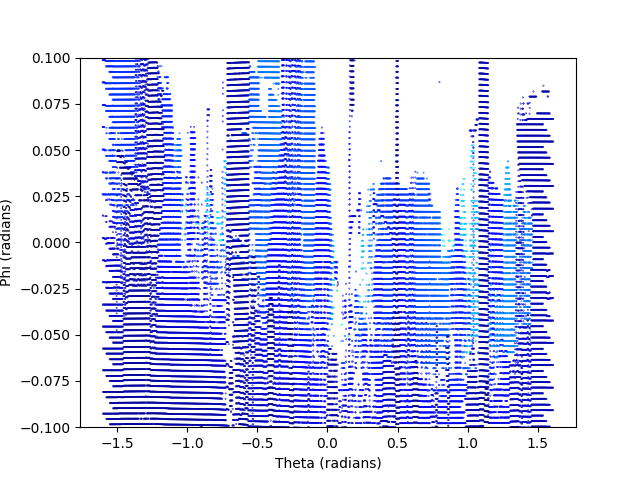

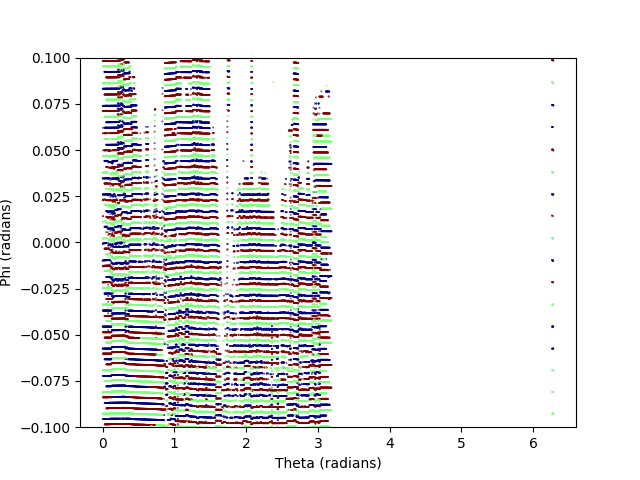

In [9]:
def plot_polar_image(points):
    #calculate angles
    theta = np.arctan2(points[:,1], points[:,0])
    phi = np.arctan2(points[:,2], np.sqrt(points[:,0]**2 + points[:,1]**2))
    distance = np.sqrt(points[:,0]**2 + points[:,1]**2 + points[:,2]**2)
    #plot polar image
    plt.figure()
    plt.scatter(theta, phi, s=0.1, c=distance, cmap='jet')
    plt.xlabel('Theta (radians)')
    plt.ylabel('Phi (radians)')
    plt.ylim([-0.1, 0.1])
    plt.show()

def plot_polar_image_beamlabels(phi, theta, beam_labels, ylim=None):
    #beam labels to int
    beam_labels = beam_labels.astype(int)

    #convert beam label to color
    colors = [0, 0.5, 1]
    #alternate colors for visualization
    color = np.zeros((beam_labels.shape[0]))
    for i in range(beam_labels.shape[0]):
        color[i] = colors[beam_labels[i] % 3]
        
    #plot polar image
    plt.figure()
    plt.scatter(phi, theta, s=0.1, c=color, cmap='jet')
    plt.xlabel('Theta (radians)')
    plt.ylabel('Phi (radians)')
    if ylim :
        plt.ylim(ylim)
    plt.show()

json_filepath = "/media/data_8T/AVLTruck_json/sequences/CityStreet_dgt_2021-07-06-10-05-55_0_s0/dataset/logical_frame_000007.json"

data = read_json(json_filepath)

points_json = data["points"]

lidar_names = list(data["lidar"].keys())
lidar_positions = {}
lidar_orientations = {}
lidar_rot_matrix = {}
for lidar_name in lidar_names:
    lidar_positions[lidar_name] = np.array([data["lidar"][lidar_name]["position"]["x"], data["lidar"][lidar_name]["position"]["y"], data["lidar"][lidar_name]["position"]["z"]])
    lidar_orientations[lidar_name] = [data["lidar"][lidar_name]["orientation"]["x"], data["lidar"][lidar_name]["orientation"]["y"], data["lidar"][lidar_name]["orientation"]["z"], data["lidar"][lidar_name]["orientation"]["w"]]
    lidar_rot_matrix[lidar_name] = Rotation.from_quat(lidar_orientations[lidar_name]).as_matrix()   

lidar_points = {}
for lidar_name in lidar_names:
    lidar_points[lidar_name] = []

for point in points_json:
    lidar_points[point["s"]].append(np.array([point['x'], point['y'], point['z'], point['i']]))

for lidar_name in lidar_names:
    lidar_points[lidar_name] = np.array(lidar_points[lidar_name])


for lidar_name in lidar_names:
    print(lidar_name)
    points = lidar_points[lidar_name].copy()
    
    #transform points with 4x4 transformation matrix
    #trans_matrix = np.array(data["lidar"]['RSFord_SHC_LF']['RSFord_SHC_LF_to_gnss']).reshape((4, 4))
#
    #points_xyz = points[:, :3]
    #points_homog = np.hstack((points_xyz, np.ones((points_xyz.shape[0], 1))))
#
    #points_homog_trans =  points_homog.dot(trans_matrix.T)
#
    ##divide by last coordinate
    #points_xyz = points_homog_trans[:,:3] / points_homog_trans[:, [3]]
#
    #points[:,:3] = points_xyz
    #
    ##apply device rotation and translation
    points[:,:3] = (points[:,:3] - lidar_positions[lidar_name]) @ lidar_rot_matrix[lidar_name]

    #points[:,:3] = (points[:,:3]) @ lidar_rot_matrix[lidar_name]
    #points[:,:3] = points[:,:3] - lidar_positions[lidar_name]

    plot_polar_image(points)
    #compute angles
    theta, phi = compute_angles(points)
    phi += np.pi/2 + 0.01
    phi = phi % (2*np.pi)

    beam_labels = np.zeros((points.shape[0]))
    beam_labels = beam_label(theta, 128, 'kmeans++')
    plot_polar_image_beamlabels(phi, theta, beam_labels, ylim=[-0.1, 0.1])
    #draw_scenes(points)
    break

#concat points
#points = np.array([])qq
#for lidar_name in lidar_names:
#    points = np.vstack((points, lidar_points[lidar_name])) if points.size else lidar_points[lidar_name]




## Generate AVLTruck beam labels

In [7]:
#json_filepath = "/media/data_8T/AVLTruck_json/sequences/CityStreet_dgt_2021-07-06-10-05-55_0_s0/dataset/logical_frame_000007.json"

source_sequences_file_path = "/media/data_8T/AVLTruck_json/sequences"

target_sequence_file_path = "/media/data_8T/AVLTruck/sequences"

#points_with_beamlabels_dict = process_json_file_truck(json_filepath)


sequences = os.listdir(source_sequences_file_path)

def process_sequence(sequence):
    dataset_folder = os.path.join(source_sequences_file_path, sequence, 'dataset')
    dataset_folder_target = os.path.join(target_sequence_file_path, sequence, 'dataset')
    #read all files that end with .json

    frame_json_filepaths = glob.glob(os.path.join(dataset_folder, '*.json'))

    for i, frame_json_filepath in enumerate(frame_json_filepaths):
        frame_id = os.path.splitext(os.path.basename(frame_json_filepath))[0].split("_")[-1]
        
        
        #check if beam labels are already computed
        #if os.path.exists(os.path.join(lidar_folder, frame_id + '_beamlabels.npy')):
        #    continue
        
        lidar_point_data = process_json_file_truck(frame_json_filepath)

        #compute angles
        #theta, phi = compute_angles(lidar_data["lidar_front"])
        #plot 
        #plot_polar_image(phi, theta, lidar_data["lidar_front"][:, 4])

        #save lidar data to target folder

        #concat lidar data
        #stack all lidar points
        lidar_names = list(lidar_point_data.keys())
        points = np.array([])
        for lidar_name in lidar_names:
            points = np.vstack((points, lidar_point_data[lidar_name])) if points.size else lidar_point_data[lidar_name]

        #save lidar data
        save_path = os.path.join(dataset_folder_target, "logical_frame_" + frame_id + '_beamlabels.npy')
        np.save(save_path, points)

#debug
#for sequence in tqdm(sequences):
#    print("processing sequence", sequence)
#    process_sequence(sequence)


import concurrent.futures as futures
with futures.ProcessPoolExecutor(max_workers=8) as executor:
    fs = [executor.submit(process_sequence, sequence) for sequence in sequences]
    for i, f in enumerate(futures.as_completed(fs)):
        print(f"finished {i+1}/{len(fs)}")

processing file /media/data_8T/AVLTruck_json/sequences/CityStreet_dgt_2021-07-08-10-22-43_0_s0/dataset/logical_frame_000017.json
processing file /media/data_8T/AVLTruck_json/sequences/PrimaryHighway_dgt_2021-07-23-10-06-52_0_s0/dataset/logical_frame_000017.json
processing file processing file/media/data_8T/AVLTruck_json/sequences/Motorway_dgt_2021-09-15-13-27-07_0_s0/dataset/logical_frame_000017.json 
/media/data_8T/AVLTruck_json/sequences/Motorway_dgt_2021-09-15-16-23-24_0_s0/dataset/logical_frame_000017.json
processing file /media/data_8T/AVLTruck_json/sequences/MinorRoad_dgt_2021-11-03-10-41-30_0_s0/dataset/logical_frame_000017.json
processing file /media/data_8T/AVLTruck_json/sequences/Motorway_dgt_2021-09-03-11-42-14_0_s0/dataset/logical_frame_000017.json
processing file /media/data_8T/AVLTruck_json/sequences/CityThoroughfare_dgt_2021-09-02-12-45-21_0_s0/dataset/logical_frame_000017.json
processing file /media/data_8T/AVLTruck_json/sequences/Motorway_dgt_2021-07-22-09-40-57_0_s0/d

## AVLTruck change db_info path

In [ ]:
import pickle as pkl
#pkl filepath
filepath = "/home/cgriesbacher/thesis/3DTrans/data/avltruck/avl_dbinfos_train_beamlabels.pkl"

#load pkl
with open(filepath, 'rb') as f:
    data = pkl.load(f)

In [ ]:
#for every key, for each data sample change path from gt_database/sequences_.... to gt_database_beamlabels/sequences_...
for key in data.keys():
    for i in range(len(data[key])):
        data[key][i]['path'] = data[key][i]['path'].replace('gt_database', 'gt_database_beamlabels')

In [ ]:
filepath_new = "/home/cgriesbacher/thesis/3DTrans/data/avltruck/avl_dbinfos_train_beamlabels.pkl"
#store new pkl
with open(filepath, 'wb') as f:
    pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)